#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import (train_test_split, 
                                     GridSearchCV,
                                     cross_validate,
                                     TimeSeriesSplit)
from sklearn.metrics import mean_absolute_error, mean_squared_error, make_scorer
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.seasonal import seasonal_decompose

## Подготовка

In [2]:
df = pd.read_csv("/datasets/taxi.csv", index_col = [0], parse_dates=[0])
df.sort_index(inplace=True)
df = df.resample("1H").sum()

In [3]:
def make_features(data, max_lag, rolling_mean_size):
    data["hour"] = data.index.hour
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek  
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
    data["rolling_mean"] = data["num_orders"].shift().rolling(rolling_mean_size).mean()
    return data

## Анализ

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


Радует, что в данных нет пропусков

In [5]:
df.index.min(), df.index.max()

(Timestamp('2018-03-01 00:00:00', freq='H'),
 Timestamp('2018-08-31 23:00:00', freq='H'))

У нас есть  данные за март-август 2018 года

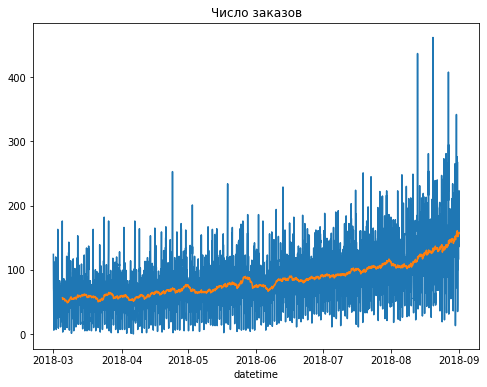

In [6]:
plt.figure(figsize=(8,6))
plt.plot(df)
plt.plot(df.rolling(100).mean())
plt.xlabel("datetime")
plt.title("Число заказов")
plt.show()

Потребность в такcи растёт. И предложение тоже

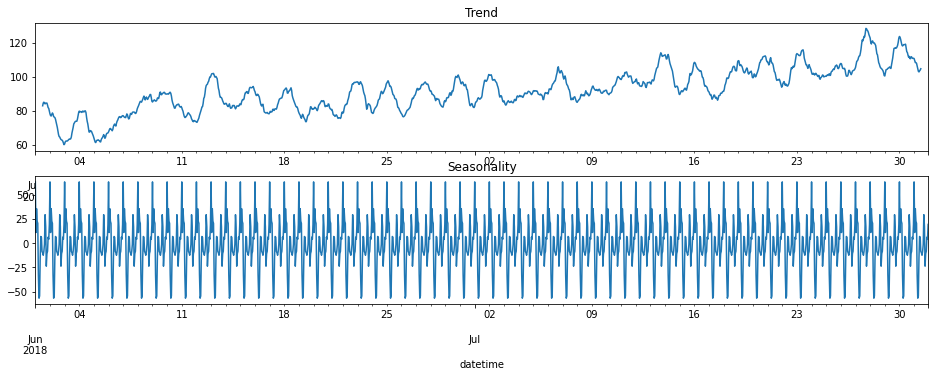

In [7]:
decomposed = seasonal_decompose(df["num_orders"]["2018-06":"2018-07"])

plt.figure(figsize=(16, 8))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.show()

Рассмотрим сезонность поближе, возьмём первую неделю июня

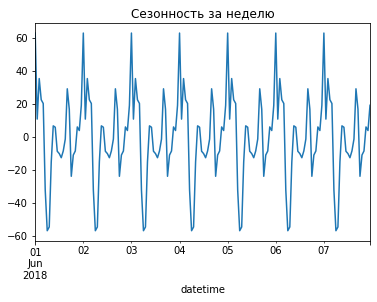

In [8]:
decomposed.seasonal["2018-06-01":"2018-06-07"].plot()
plt.title("Сезонность за неделю")
plt.show()

Видно, что пик заказов приходится на вечер, а минимум на глубокую ночь

## Обучение

### Создание признаков

In [9]:
df = make_features(df, 5, 10)
df.dropna(inplace=True)
train, test = train_test_split(df, test_size=0.1, shuffle=False)

train_features = train.drop("num_orders", axis=1)
test_features = test.drop("num_orders", axis=1)

train_target = train["num_orders"]
test_target = test["num_orders"]

In [10]:
sc = StandardScaler()
train_features = sc.fit_transform(train_features)
test_features = sc.transform(test_features)

In [11]:
def rmse(Y_true, Y_pred):
    return mean_squared_error(Y_true, Y_pred)**0.5
RMSE = make_scorer(rmse, greater_is_better=False)

In [12]:
cv = TimeSeriesSplit(n_splits=5)

### Линейная регрессия

In [13]:
linear = LinearRegression()
cross_validate(linear, train_features, train_target, scoring=RMSE, cv=cv)["test_score"].mean()

-31.565836456282995

### Случайный лес

In [14]:
%%time
grid_forest = {"n_estimators": [50, 100, 150],
               "max_depth": [10, 20, 30],
               "max_features": ["log2", None]}
forest = RandomForestRegressor()
grid = GridSearchCV(forest, param_grid=grid_forest, cv=cv, scoring=RMSE)
model_grid = grid.fit(train_features, train_target)
print(model_grid.best_params_)
print(model_grid.best_score_)

{'max_depth': 30, 'max_features': None, 'n_estimators': 100}
-25.233835690425668
CPU times: user 55.5 s, sys: 478 ms, total: 56 s
Wall time: 56.1 s


In [15]:
params = model_grid.best_params_
forest.set_params(**params)
forest.fit(train_features, train_target)

RandomForestRegressor(max_depth=30, max_features=None)

###  CatBoost

In [16]:
model_catboost = CatBoostRegressor(iterations=100, depth=10, verbose=False)
cross_validate(model_catboost, train_features, train_target, scoring=RMSE, cv=cv)["test_score"].mean()

-26.792803954931333

Оптимальной моделью будет случайный лес, её и выберем

## Тестирование

In [17]:
mean_absolute_error(forest.predict(test_features), test_target)

34.19113378684808

In [18]:
rmse(forest.predict(test_features), test_target)

45.44960404847621

Построим графики целевого и предсказанного ряда

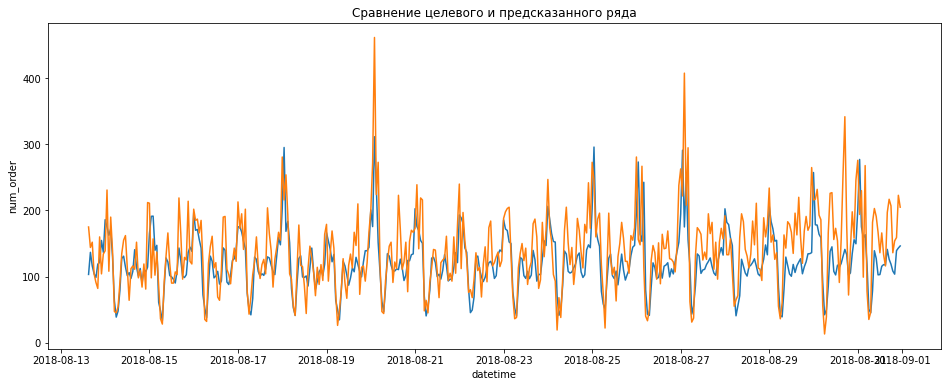

In [22]:
plt.figure(figsize=(16,6))
plt.plot(pd.Series(forest.predict(test_features), index=test_target.index))
plt.plot(test_target)
plt.xlabel("datetime")
plt.ylabel("num_order")
plt.title("Сравнение целевого и предсказанного ряда")
plt.show()

Видно, что места пиков и провалов модель предсказала достаточно точно, но не смогда точно предсказать значения в этих точках.
Так же заметно, как ближе к концу ряда предсказания все дальше отдаляются от реальности

## Вывод

В ходе анализа временного ряда была вяылена сезонность с периодом в 1 сутки, мексимум которой приходися на вечер, минимум - на ночь. Кросс валидацией были проверены три модели - линейная регрессия, случайный лес и CatBoost. Лучший результат показала можель случайного леса. На тестовой выборке она показала метрики  MAE - 33, RMSE - 45